In [112]:

from pytorch_tabnet.tab_model import TabNetClassifier
import requests as r
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pickle


Den Datensatz laden

In [136]:


play_data = pd.read_csv(
    'data_final.1.csv'
)



Einteilung Nach Trainings-, Validierungs-, und Testdatensatz

In [137]:

import numpy as np
from sklearn.model_selection import train_test_split


unique_game_ids = play_data['GameID'].unique()


train_game_ids, remaining_game_ids = train_test_split(unique_game_ids, test_size=0.2, random_state=42)
train_game_ids, valid_game_ids = train_test_split(train_game_ids, test_size=0.2, random_state=42)
test_game_ids =remaining_game_ids


train_df = play_data[play_data['GameID'].isin(train_game_ids)]
valid_df = play_data[play_data['GameID'].isin(valid_game_ids)]
test_df = play_data[play_data['GameID'].isin(test_game_ids)]





In [ ]:
train_game_ids = set(train_df['GameID'])
valid_game_ids = set(valid_df['GameID'])
test_game_ids = set(test_df['GameID'])

intersection_train_valid = train_game_ids.intersection(valid_game_ids)
intersection_train_test = train_game_ids.intersection(test_game_ids)
intersection_valid_test = valid_game_ids.intersection(test_game_ids)

if len(intersection_train_valid) == 0 and len(intersection_train_test) == 0 and len(intersection_valid_test) == 0:
    print("Keine gemeinsamen GameIDs zwischen train_df, valid_df und test_df.")
else:
    print("Es gibt gemeinsame GameIDs zwischen train_df, valid_df und test_df.")

Hier werden die verschiedenen Modelle geladen

In [ ]:
rf_filename = "RandomForest_final.pkl"
with open(rf_filename, 'rb') as file:
    rf_model = pickle.load(file)
xgb_filename = "xgbAll_final.pkl"
with open(xgb_filename, 'rb') as file:
    xgb_model = pickle.load(file)
tn_filename = "TabNet_final.pkl"
with open(tn_filename, 'rb') as file:
    tn_model = pickle.load(file)

Preprocessing

In [ ]:
tn = TabNetClassifier(verbose=1, seed=42)

y_train_tn = train_df['Winner']
y_valid_tn = valid_df['Winner']
y_test_tn = test_df['Winner']
X_train_tn = train_df.drop('Winner', axis=1)
X_valid_tn = valid_df.drop('Winner', axis=1)
X_test_tn = test_df.drop('Winner', axis=1)

y_valid_tn = y_valid_tn.astype(int)
y_train_tn = y_train_tn.astype(int)
y_test_tn = y_test_tn.astype(int)
cardinality_cols = ['type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['GameID','scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']

scaler = StandardScaler()
X_train_numerical_tn = scaler.fit_transform(X_train_tn[numerical_cols])
X_valid_numerical_tn = scaler.transform(X_valid_tn[numerical_cols])
X_test_numerical_tn = scaler.transform(X_test_tn[numerical_cols])


encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_tn = encoder.fit_transform(X_train_tn[cardinality_cols]).toarray()
X_valid_categorical_tn = encoder.transform(X_valid_tn[cardinality_cols]).toarray()
X_test_categorical_tn = encoder.transform(X_test_tn[cardinality_cols]).toarray()


X_train_processed_tn = np.concatenate([X_train_numerical_tn, X_train_categorical_tn], axis=1)
X_valid_processed_tn = np.concatenate([X_valid_numerical_tn, X_valid_categorical_tn], axis=1)
X_test_processed_tn = np.concatenate([X_test_numerical_tn, X_test_categorical_tn], axis=1)

In [143]:

y_train_rf = train_df['Winner']
y_valid_rf = valid_df['Winner']
y_test_rf = test_df['Winner']
X_train_rf = train_df.drop('Winner', axis=1)
X_valid_rf = valid_df.drop('Winner', axis=1)
X_test_rf = test_df.drop('Winner', axis=1)


y_valid_rf = y_valid_rf.astype(int)
y_train_rf = y_train_rf.astype(int)
y_test_rf = y_test_rf.astype(int)


cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']

scaler = StandardScaler()
X_train_numerical_rf = scaler.fit_transform(X_train_rf[numerical_cols])
X_valid_numerical_rf = scaler.transform(X_valid_rf[numerical_cols])
X_test_numerical_rf = scaler.transform(X_test_rf[numerical_cols])


encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_rf = encoder.fit_transform(X_train_rf[cardinality_cols]).toarray()
X_valid_categorical_rf = encoder.transform(X_valid_rf[cardinality_cols]).toarray()
X_test_categorical_rf = encoder.transform(X_test_rf[cardinality_cols]).toarray()


X_train_processed_rf = np.concatenate([X_train_numerical_rf, X_train_categorical_rf], axis=1)
X_valid_processed_rf = np.concatenate([X_valid_numerical_rf, X_valid_categorical_rf], axis=1)
X_test_processed_rf = np.concatenate([X_test_numerical_rf, X_test_categorical_rf], axis=1)

In [144]:
y_train_xgb = train_df['Winner']
y_valid_xgb = valid_df['Winner']
y_test_xgb = test_df['Winner']
X_train_xgb = train_df.drop('Winner', axis=1)
X_valid_xgb = valid_df.drop('Winner', axis=1)
X_test_xgb = test_df.drop('Winner', axis=1)


y_valid_xgb = y_valid_xgb.astype(int)
y_train_xgb = y_train_xgb.astype(int)
y_test_xgb = y_test_xgb.astype(int)
cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']


scaler = StandardScaler()
X_train_numerical_xgb = scaler.fit_transform(X_train_xgb[numerical_cols])
X_valid_numerical_xgb = scaler.transform(X_valid_xgb[numerical_cols])
X_test_numerical_xgb = scaler.transform(X_test_xgb[numerical_cols])

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(X_train_xgb[cardinality_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(X_valid_xgb[cardinality_cols]).toarray()
X_test_categorical_xgb = encoder.transform(X_test_xgb[cardinality_cols]).toarray()


X_train_processed_xgb = np.concatenate([X_train_numerical_xgb, X_train_categorical_xgb], axis=1)
X_valid_processed_xgb = np.concatenate([X_valid_numerical_xgb, X_valid_categorical_xgb], axis=1)
X_test_processed_xgb = np.concatenate([X_test_numerical_xgb, X_test_categorical_xgb], axis=1)

In [145]:
preds_test_xgb = xgb_model.predict(X_test_processed_xgb )

In [146]:
preds_test_rf = rf_model.predict(X_test_processed_rf )

In [147]:
preds_test_tn = tn_model.predict(X_test_processed_tn )

Hier kann der Datensatz nach den Punkteabstände gefiltert werden

In [148]:
preds_test_xgb = preds_test_xgb[X_test_xgb['scoring_game'] == 2]
preds_test_rf = preds_test_rf[X_test_rf['scoring_game'] == 2]
preds_test_tn = preds_test_tn[X_test_tn['scoring_game'] == 2]
y_test_xgb = y_test_xgb[X_test_xgb['scoring_game'] == 2]
y_test_rf = y_test_rf[X_test_rf['scoring_game'] == 2]
y_test_tn = y_test_tn[X_test_tn['scoring_game'] == 2]

In [149]:
accuracy_test_rf = accuracy_score(y_test_rf, preds_test_rf)
precision_test_rf = precision_score(y_test_rf, preds_test_rf)
recall_test_rf = recall_score(y_test_rf, preds_test_rf)
f1_test_rf = f1_score(y_test_rf, preds_test_rf)
auc_test_rf = roc_auc_score(y_test_rf, preds_test_rf)
cm_test_rf = confusion_matrix(y_test_rf, preds_test_rf)
cm_str_test_rf = np.array2string(cm_test_rf, separator=', ')

# Ergebnisse ausgeben
print("Accuracy: {:.4f}".format(accuracy_test_rf))
print("Precision: {:.4f}".format(precision_test_rf))
print("Recall: {:.4f}".format(recall_test_rf))
print("F1 Score: {:.4f}".format(f1_test_rf))
print('Confusion Matrix: ', cm_str_test_rf)

Accuracy: 0.8360
Precision: 0.8014
Recall: 0.9202
F1 Score: 0.8567
Confusion Matrix:  [[5514, 1937],
 [ 678, 7815]]


In [150]:
accuracy_test_tn = accuracy_score(y_test_tn, preds_test_tn)
precision_test_tn = precision_score(y_test_tn, preds_test_tn)
recall_test_tn = recall_score(y_test_tn, preds_test_tn)
f1_test_tn = f1_score(y_test_tn, preds_test_tn)
auc_test_tn = roc_auc_score(y_test_tn, preds_test_tn)
cm_test_tn = confusion_matrix(y_test_tn, preds_test_tn)
cm_str_test_tn = np.array2string(cm_test_tn, separator=', ')

print("Accuracy: {:.4f}".format(accuracy_test_tn))
print("Precision: {:.4f}".format(precision_test_tn))
print("Recall: {:.4f}".format(recall_test_tn))
print("F1 Score: {:.4f}".format(f1_test_tn))
print('Confusion Matrix: ', cm_str_test_tn)

Accuracy: 0.6843
Precision: 0.6650
Recall: 0.8209
F1 Score: 0.7348
Confusion Matrix:  [[3939, 3512],
 [1521, 6972]]


In [151]:
accuracy_test_xgb = accuracy_score(y_test_xgb, preds_test_xgb)
precision_test_xgb = precision_score(y_test_xgb, preds_test_xgb)
recall_test_xgb = recall_score(y_test_xgb, preds_test_xgb)
f1_test_xgb = f1_score(y_test_xgb, preds_test_xgb)
auc_test_xgb = roc_auc_score(y_test_xgb, preds_test_xgb)
cm_test_xgb = confusion_matrix(y_test_xgb, preds_test_xgb)
cm_str_test_xgb = np.array2string(cm_test_xgb, separator=', ')


print("Accuracy: {:.4f}".format(accuracy_test_xgb))
print("Precision: {:.4f}".format(precision_test_xgb))
print("Recall: {:.4f}".format(recall_test_xgb))
print("F1 Score: {:.4f}".format(f1_test_xgb))
print('Confusion Matrix: ', cm_str_test_xgb)

Accuracy: 0.8597
Precision: 0.8358
Recall: 0.9168
F1 Score: 0.8744
Confusion Matrix:  [[5921, 1530],
 [ 707, 7786]]


Hier werden die Plots des gefiltersten Datensatzes generiert

In [39]:
def plot_data_xgb(time):
  preds_time_xgb = preds_test_xgb[((X_test_xgb['time_remaining'] <= time) &(X_test_xgb['time_remaining'] >= time-3))]
  y_time_xgb = y_test_xgb[((X_test_xgb['time_remaining'] <= time) & (X_test_xgb['time_remaining'] >= time-3))]
  accuracy = accuracy_score(y_time_xgb, preds_time_xgb)
  return accuracy

In [40]:
def plot_data_rf(time):
  preds_time_rf = preds_test_rf[((X_test_rf['time_remaining'] <= time) &(X_test_rf['time_remaining'] >= time-3))]
  y_time_rf = y_test_rf[((X_test_rf['time_remaining'] <= time) & (X_test_rf['time_remaining'] >= time-3))]
  accuracy = accuracy_score(y_time_rf, preds_time_rf)
  return accuracy

In [41]:
def plot_data_tn(time):
  preds_time_tn = preds_test_tn[((X_test_tn['time_remaining'] <= time) &(X_test_tn['time_remaining'] >= time-3))]
  y_time_tn = y_test_tn[((X_test_tn['time_remaining'] <= time) & (X_test_tn['time_remaining'] >= time-3))]
  accuracy = accuracy_score(y_time_tn, preds_time_tn)
  return accuracy

In [66]:
def plot_data_xgb(time):
  preds_time_xgb = preds_test_xgb[((X_test_xgb['time_remaining'] <= time) &(X_test_xgb['time_remaining'] >= time-3)&(X_test_xgb['scoring_game'] == 1))]
  y_time_xgb = y_test_xgb[((X_test_xgb['time_remaining'] <= time) & (X_test_xgb['time_remaining'] >= time-3)&(X_test_xgb['scoring_game'] == 1))]
  accuracy = accuracy_score(y_time_xgb, preds_time_xgb)
  return accuracy

In [67]:
def plot_data_rf(time):
  preds_time_rf = preds_test_rf[((X_test_rf['time_remaining'] <= time) &(X_test_rf['time_remaining'] >= time-3)&(X_test_rf['scoring_game'] == 1))]
  y_time_rf = y_test_rf[((X_test_rf['time_remaining'] <= time) & (X_test_rf['time_remaining'] >= time-3)&(X_test_rf['scoring_game'] == 1))]
  accuracy = accuracy_score(y_time_rf, preds_time_rf)
  return accuracy

In [68]:
def plot_data_tn(time):
  preds_time_tn = preds_test_tn[((X_test_tn['time_remaining'] <= time) &(X_test_tn['time_remaining'] >= time-3)&(X_test_tn['scoring_game'] == 1))]
  y_time_tn = y_test_tn[((X_test_tn['time_remaining'] <= time) & (X_test_tn['time_remaining'] >= time-3)&(X_test_tn['scoring_game'] == 1))]
  accuracy = accuracy_score(y_time_tn, preds_time_tn)
  return accuracy

In [69]:
time_values = list(np.arange(60, 0, -3))

auc_values_xgb = []
time_plot = []

for time in time_values:
    auc_values_xgb.append(plot_data_xgb(time))
    time_plot.append(time)


In [70]:
time_values = list(np.arange(60, 0, -3))

auc_values_rf = []
time_plot = []

for time in time_values:
    auc_values_rf.append(plot_data_rf(time))
    time_plot.append(time)

In [71]:
time_values = list(np.arange(60, 0, -3))

auc_values_tn = []
time_plot = []

for time in time_values:
    auc_values_tn.append(plot_data_tn(time))
    time_plot.append(time)

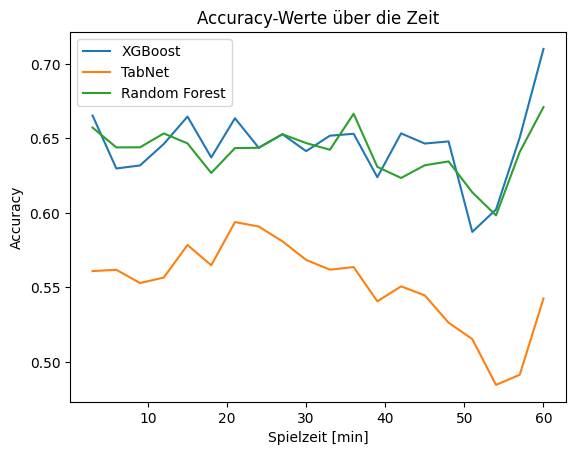

In [73]:
import matplotlib.pyplot as plt


x = time_plot[::-1]
y_xgb = auc_values_xgb
y_tn = auc_values_tn
y_rf = auc_values_rf


plt.plot(x, y_xgb, label='XGBoost')
plt.plot(x, y_tn, label='TabNet')
plt.plot(x, y_rf, label='Random Forest')


plt.xlabel('Spielzeit [min]')
plt.ylabel('Accuracy')
plt.title('Accuracy-Werte über die Zeit')


plt.legend()


plt.show()

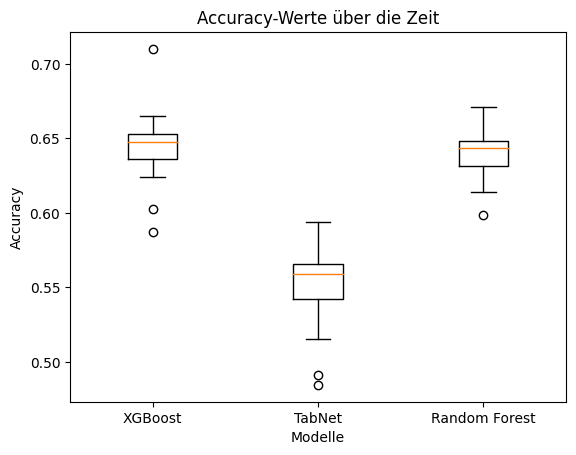

In [74]:
import matplotlib.pyplot as plt


x = time_plot[::-1]
y_xgb = auc_values_xgb
y_tn = auc_values_tn
y_rf = auc_values_rf


data = [y_xgb, y_tn, y_rf]


plt.boxplot(data)


plt.xlabel('Modelle')
plt.ylabel('Accuracy')
plt.title('Accuracy-Werte über die Zeit')


labels = ['XGBoost', 'TabNet', 'Random Forest']
plt.xticks(range(1, len(labels) + 1), labels)


plt.show()
